In [46]:
import sys

sys.path.append(r"D:\Machine Learning models\helper functions")

from helper_functions import Impute
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette("Set2")

plasma_palette=sns.color_palette("plasma")
cool_palette=sns.color_palette("cool")
viridis_palette=sns.color_palette("viridis")
inferno_palette=sns.color_palette("inferno")
icefire_palette=sns.color_palette("icefire")
icefire_r_palette=sns.color_palette("icefire_r")
mako_palette=sns.color_palette("mako")

import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
from sklearn.preprocessing import LabelEncoder,StandardScaler,RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,roc_curve,roc_auc_score,confusion_matrix

In [2]:
uci=pd.read_csv("Dataset/heart_disease_uci.csv")
uci.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [3]:
uci.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [4]:
uci.describe()

,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


### Convet num to 0 and 1 only

In [5]:
uci["num"]=uci["num"].apply(lambda x:1 if x>=1 else 0)
uci.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [6]:
uci.drop("dataset",axis=1,inplace=True)

In [7]:
uci.drop("id",axis=1,inplace=True)

# Missing values

In [8]:
uci.isna().sum().sort_values()

age           0
sex           0
cp            0
num           0
restecg       2
chol         30
thalch       55
exang        55
trestbps     59
oldpeak      62
fbs          90
slope       309
thal        486
ca          611
dtype: int64

## Drop columns where it has 5% of data missimg value or less

In [9]:
threshold=len(uci)*0.05

In [10]:
threshold

46.0

In [11]:
cols_to_drop=uci.columns[uci.isna().sum()<threshold]
cols_to_drop

Index(['age', 'sex', 'cp', 'chol', 'restecg', 'num'], dtype='object')

In [12]:
uci.dropna(subset=cols_to_drop,inplace=True)

In [13]:
uci.isna().sum().sort_values()

age           0
sex           0
cp            0
chol          0
restecg       0
num           0
thalch       52
exang        52
trestbps     56
oldpeak      59
fbs          89
slope       286
thal        456
ca          580
dtype: int64

### Impute the numeric feature with Median and the categorical with mode

In [14]:
numeric_features=uci.select_dtypes(["int","float"]).columns
numeric_features=numeric_features[[0,1,2,3,4]]
numeric_features

Index(['age', 'trestbps', 'chol', 'thalch', 'oldpeak'], dtype='object')

In [15]:
ca_index=pd.Index(["ca"])
cat_features=uci.select_dtypes(["object"]).columns
cat_features=cat_features.append(ca_index)

In [16]:
cat_features

Index(['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'ca'], dtype='object')

In [17]:
X_cat=uci[cat_features].values
X_num=uci[numeric_features].values
y=uci["num"].values

In [18]:
uci_imputed=Impute(X_num=X_num,X_cat=X_cat,y=y,cat_features=cat_features,numeric_features=numeric_features,target_name="num")
uci_imputed

,sex,cp,fbs,restecg,exang,slope,thal,ca,age,trestbps,chol,thalch,oldpeak,num
0,Male,asymptomatic,False,normal,True,flat,normal,0.0,62.0,110.0,0.0,120.0,0.5,1
1,Male,atypical angina,False,normal,False,upsloping,normal,0.0,42.0,120.0,295.0,162.0,0.0,0
2,Female,atypical angina,False,normal,False,upsloping,normal,0.0,47.0,140.0,257.0,135.0,1.0,0
3,Male,non-anginal,False,st-t abnormality,False,flat,normal,0.0,35.0,130.0,161.0,139.5,0.5,0
4,Male,asymptomatic,True,st-t abnormality,False,flat,reversable defect,0.0,65.0,160.0,0.0,122.0,0.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,Female,atypical angina,False,st-t abnormality,False,flat,normal,0.0,54.0,140.0,309.0,140.0,0.0,0
884,Male,non-anginal,False,normal,False,flat,normal,0.0,49.0,130.0,142.0,139.5,0.5,1
885,Female,non-anginal,False,normal,False,flat,normal,0.0,50.0,120.0,219.0,158.0,1.6,0
886,Male,atypical angina,False,normal,False,upsloping,normal,0.0,52.0,120.0,325.0,172.0,0.2,0


In [19]:
uci_imputed.isna().sum()

sex         0
cp          0
fbs         0
restecg     0
exang       0
slope       0
thal        0
ca          0
age         0
trestbps    0
chol        0
thalch      0
oldpeak     0
num         0
dtype: int64

- finally we have no missing values :)

In [20]:
uci_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888 entries, 0 to 887
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sex       888 non-null    object
 1   cp        888 non-null    object
 2   fbs       888 non-null    object
 3   restecg   888 non-null    object
 4   exang     888 non-null    object
 5   slope     888 non-null    object
 6   thal      888 non-null    object
 7   ca        888 non-null    object
 8   age       888 non-null    object
 9   trestbps  888 non-null    object
 10  chol      888 non-null    object
 11  thalch    888 non-null    object
 12  oldpeak   888 non-null    object
 13  num       888 non-null    int64 
dtypes: int64(1), object(13)
memory usage: 97.2+ KB


In [21]:
uci_imputed["age"]=uci_imputed["age"].astype("int")
uci_imputed["trestbps"]=uci_imputed["trestbps"].astype("float")
uci_imputed["chol"]=uci_imputed["chol"].astype("float")
uci_imputed["thalch"]=uci_imputed["thalch"].astype("float")
uci_imputed["oldpeak"]=uci_imputed["oldpeak"].astype("float")
uci_imputed["num"]=uci_imputed["num"].astype("int")

In [22]:
uci_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888 entries, 0 to 887
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sex       888 non-null    object 
 1   cp        888 non-null    object 
 2   fbs       888 non-null    object 
 3   restecg   888 non-null    object 
 4   exang     888 non-null    object 
 5   slope     888 non-null    object 
 6   thal      888 non-null    object 
 7   ca        888 non-null    object 
 8   age       888 non-null    int32  
 9   trestbps  888 non-null    float64
 10  chol      888 non-null    float64
 11  thalch    888 non-null    float64
 12  oldpeak   888 non-null    float64
 13  num       888 non-null    int32  
dtypes: float64(4), int32(2), object(8)
memory usage: 90.3+ KB


# Handling outliers

In [23]:
numeric_features=uci_imputed.select_dtypes(["int","float"]).columns
numeric_features

Index(['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'num'], dtype='object')

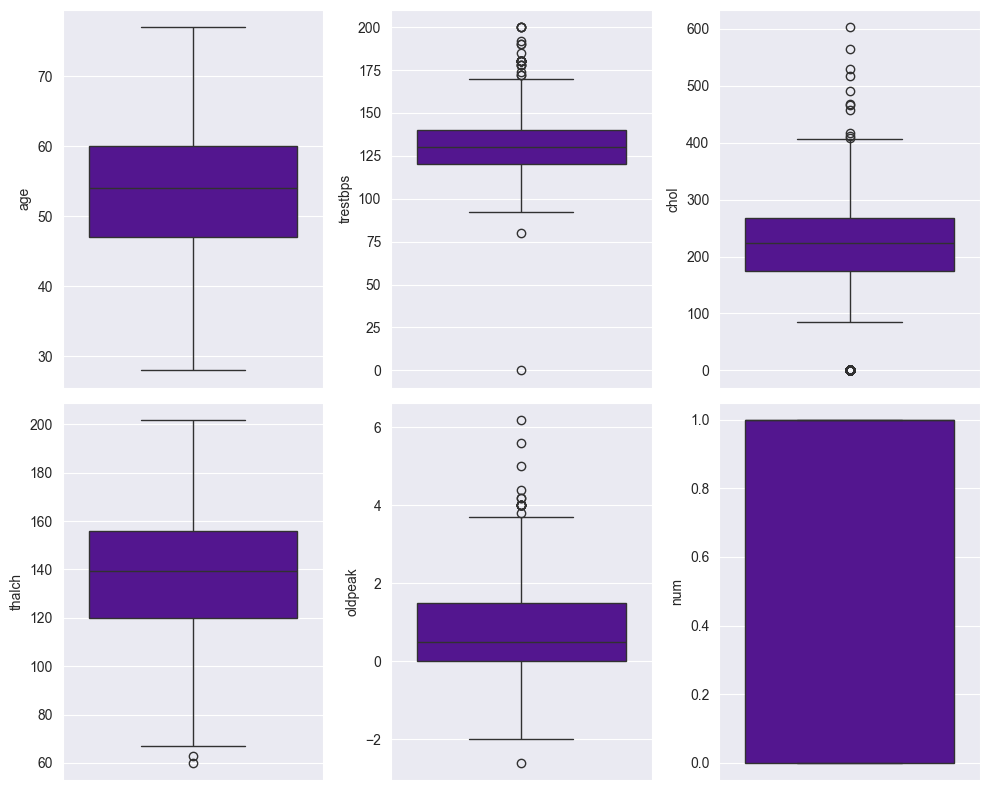

In [24]:
plt.figure(figsize=(10,8))
for idx,label in enumerate(numeric_features):
    plt.subplot(2,3,idx+1)
    sns.boxplot(y=uci_imputed[label],data=uci_imputed,palette=plasma_palette)
plt.tight_layout()
plt.show()

- Here we will rempve the outlier from chol

In [25]:
def outlier(series:pd.Series)->float:
    Q1=series.quantile(0.25)
    Q3=series.quantile(0.75)

    IQR=Q3-Q1

    upper_bound=Q3+1.5*IQR
    lower_bound=Q1-1.5*IQR

    mask=(series<=upper_bound)&(series>=lower_bound)
    return mask

In [26]:
mask_chol=outlier(uci_imputed["chol"])
uci_imputed=uci_imputed[mask_chol]

# Feature Selection

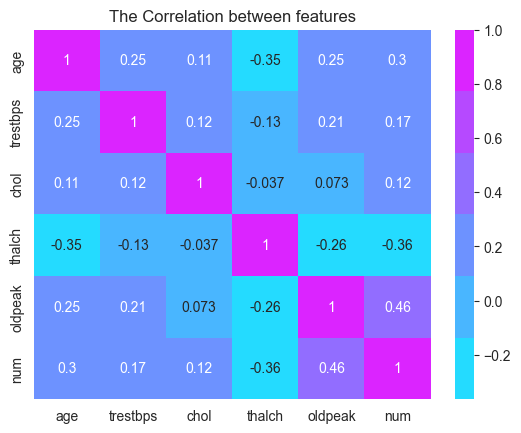

In [27]:
g=sns.heatmap(uci_imputed.corr(numeric_only=True),annot=True,cmap=cool_palette)
g.set_title("The Correlation between features")
plt.show()

# Data Analysis

In [28]:
uci_imputed.head()

,sex,cp,fbs,restecg,exang,slope,thal,ca,age,trestbps,chol,thalch,oldpeak,num
1,Male,atypical angina,False,normal,False,upsloping,normal,0.0,42,120.0,295.0,162.0,0.0,0
2,Female,atypical angina,False,normal,False,upsloping,normal,0.0,47,140.0,257.0,135.0,1.0,0
3,Male,non-anginal,False,st-t abnormality,False,flat,normal,0.0,35,130.0,161.0,139.5,0.5,0
5,Male,asymptomatic,True,lv hypertrophy,True,upsloping,reversable defect,3.0,63,130.0,330.0,132.0,1.8,1
6,Female,asymptomatic,True,lv hypertrophy,True,flat,fixed defect,2.0,58,170.0,225.0,146.0,2.8,1


### How many people have heart disease?

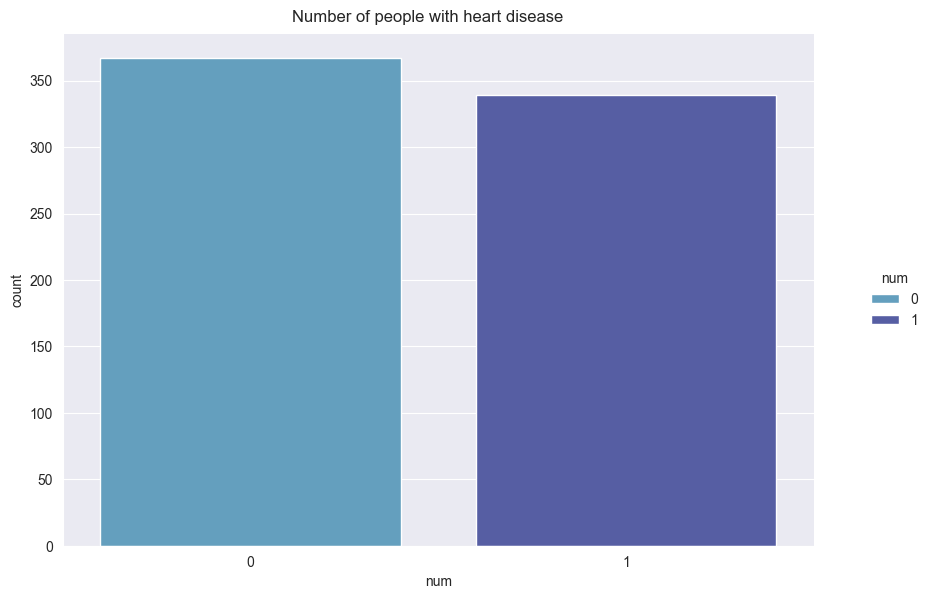

In [29]:
g=sns.catplot(x="num",hue="num",data=uci_imputed,palette=icefire_palette,kind="count")
g.fig.suptitle("Number of people with heart disease",y=1.01)
g.figure.set_size_inches(10,6)
plt.show()

### Which gender has the most number of heart disease?

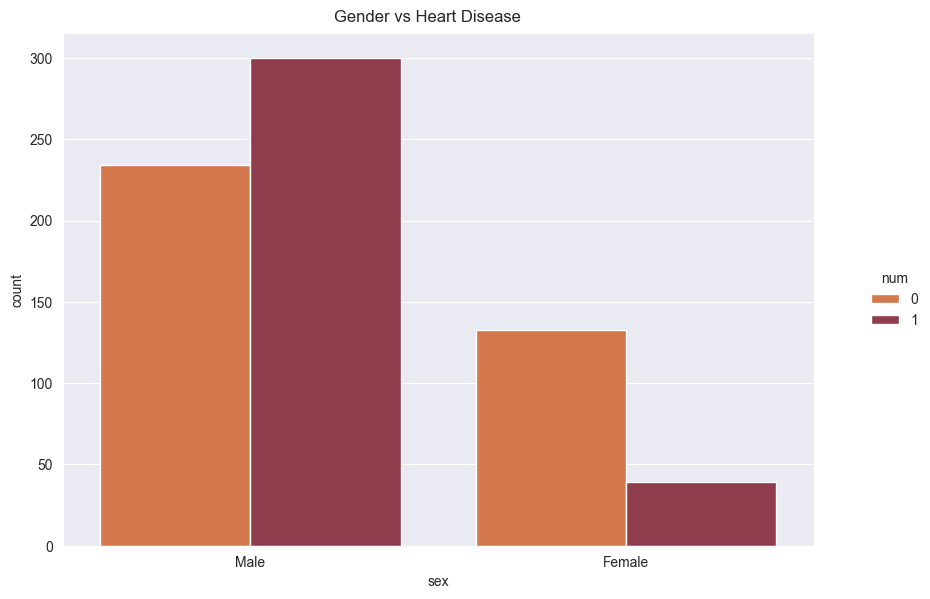

In [30]:
g=sns.catplot(x="sex",hue="num",data=uci_imputed,palette=icefire_r_palette,kind="count")
g.fig.suptitle("Gender vs Heart Disease",y=1.01)
g.figure.set_size_inches(10,6)
plt.show()

### Which chest pain type (cp) has the most number of heart Disease?

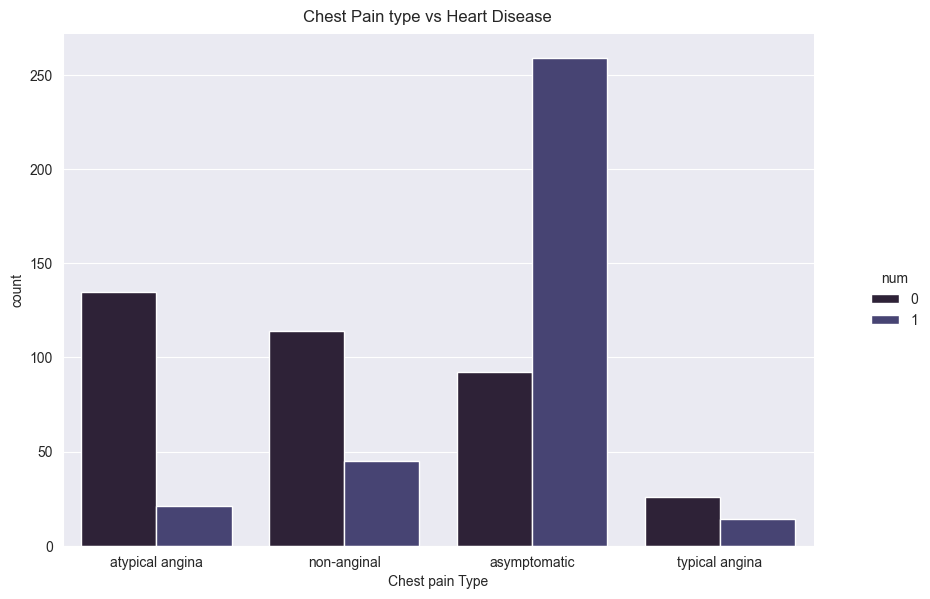

In [31]:
g=sns.catplot(x="cp",hue="num",data=uci_imputed,palette=mako_palette,kind="count")
g.fig.suptitle("Chest Pain type vs Heart Disease",y=1.01)
g.figure.set_size_inches(10,6)
g.set(xlabel="Chest pain Type")
plt.show()

### Is having fasting blood sugar > 120 mg/dl can affect on having heart disease?

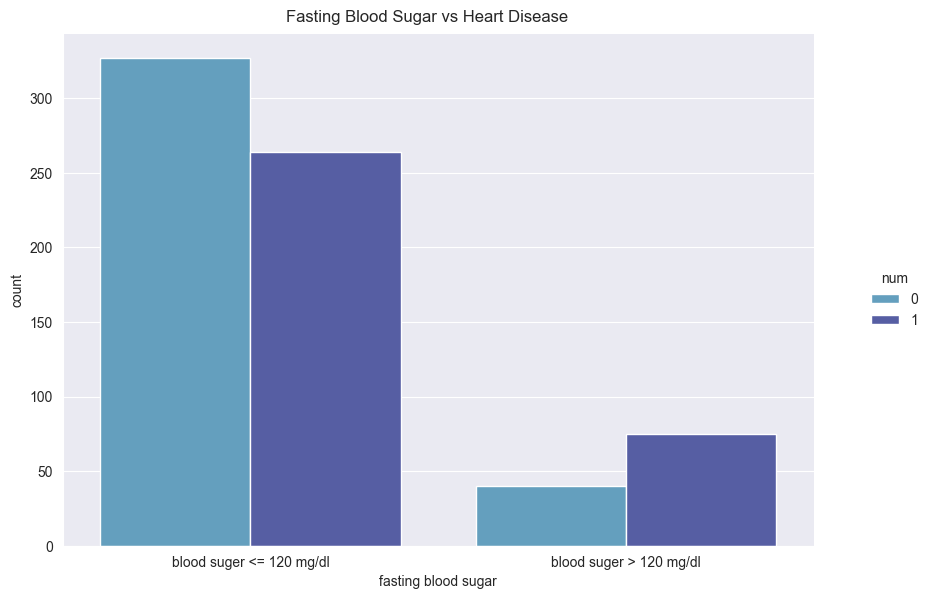

In [32]:
g=sns.catplot(x="fbs",hue="num",data=uci_imputed,palette=icefire_palette,kind="count")
g.fig.suptitle("Fasting Blood Sugar vs Heart Disease",y=1.01)
g.figure.set_size_inches(10,6)
g.set(xlabel="fasting blood sugar")
plt.xticks(ticks=["False","True"],labels=["blood suger <= 120 mg/dl","blood suger > 120 mg/dl"])
plt.show()

### What is the relation between resting electrocardiographic results and having Heart Disease?

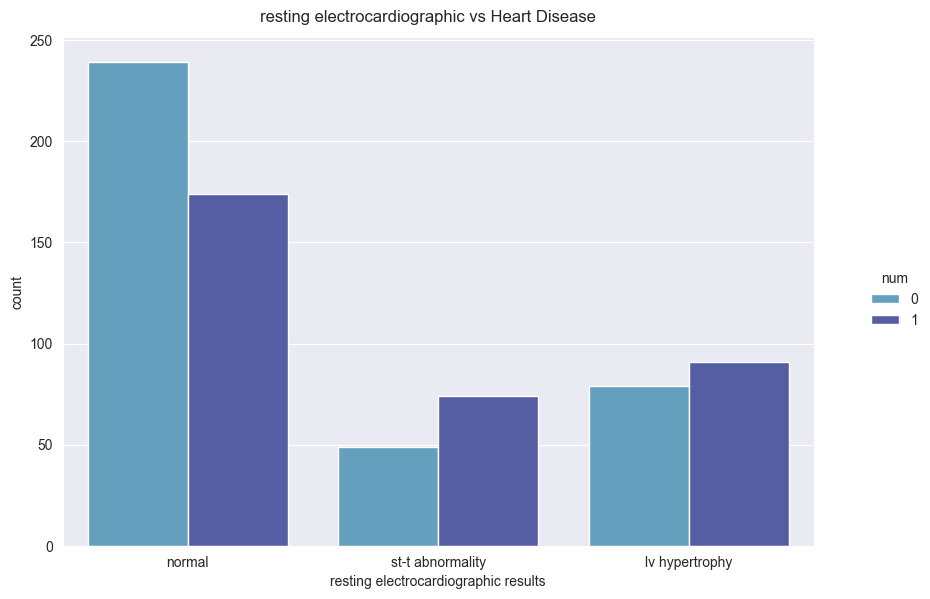

In [33]:
g=sns.catplot(x="restecg",hue="num",data=uci_imputed,palette=icefire_palette,kind="count")
g.fig.suptitle("resting electrocardiographic vs Heart Disease",y=1.01)
g.figure.set_size_inches(10,6)
g.set(xlabel="resting electrocardiographic results")
plt.show()

### what is the reltionship between having heart disease and other numeric features

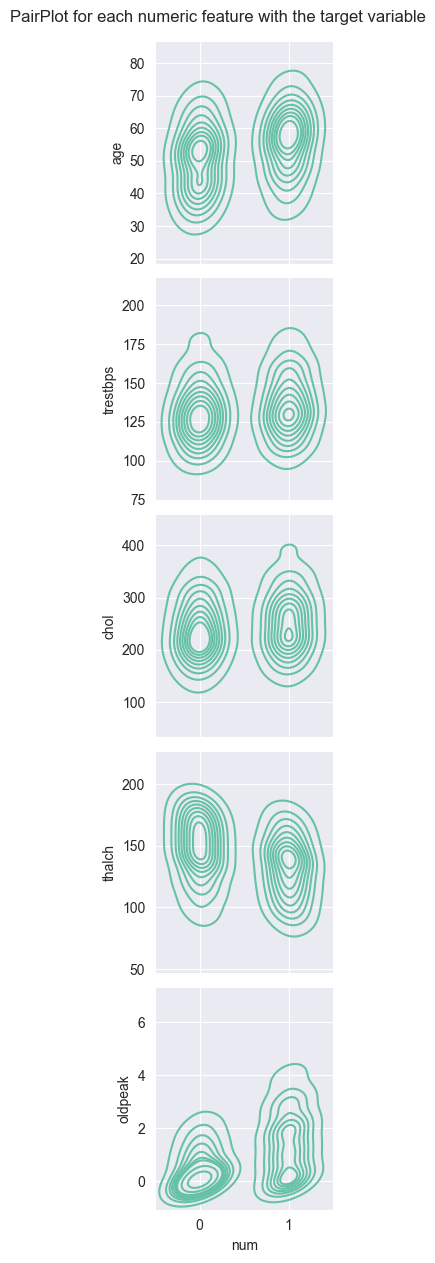

In [34]:
g=sns.pairplot(data=uci_imputed,x_vars=["num"],y_vars=["age","trestbps","chol","thalch","oldpeak"],palette=plasma_palette,kind="kde")
g.fig.suptitle("PairPlot for each numeric feature with the target variable",y=1.01)
plt.show()

# Feature Enginearing

In [35]:
uci_imputed.head()

,sex,cp,fbs,restecg,exang,slope,thal,ca,age,trestbps,chol,thalch,oldpeak,num
1,Male,atypical angina,False,normal,False,upsloping,normal,0.0,42,120.0,295.0,162.0,0.0,0
2,Female,atypical angina,False,normal,False,upsloping,normal,0.0,47,140.0,257.0,135.0,1.0,0
3,Male,non-anginal,False,st-t abnormality,False,flat,normal,0.0,35,130.0,161.0,139.5,0.5,0
5,Male,asymptomatic,True,lv hypertrophy,True,upsloping,reversable defect,3.0,63,130.0,330.0,132.0,1.8,1
6,Female,asymptomatic,True,lv hypertrophy,True,flat,fixed defect,2.0,58,170.0,225.0,146.0,2.8,1


In [36]:
le=LabelEncoder()
uci_imputed["sex"]=le.fit_transform(uci_imputed["sex"].values.reshape(-1,1))
uci_imputed["fbs"]=le.fit_transform(uci_imputed["fbs"].values.reshape(-1,1))
uci_imputed["exang"]=le.fit_transform(uci_imputed["exang"].values.reshape(-1,1))

In [37]:
uci_imputed.head()

,sex,cp,fbs,restecg,exang,slope,thal,ca,age,trestbps,chol,thalch,oldpeak,num
1,1,atypical angina,0,normal,0,upsloping,normal,0.0,42,120.0,295.0,162.0,0.0,0
2,0,atypical angina,0,normal,0,upsloping,normal,0.0,47,140.0,257.0,135.0,1.0,0
3,1,non-anginal,0,st-t abnormality,0,flat,normal,0.0,35,130.0,161.0,139.5,0.5,0
5,1,asymptomatic,1,lv hypertrophy,1,upsloping,reversable defect,3.0,63,130.0,330.0,132.0,1.8,1
6,0,asymptomatic,1,lv hypertrophy,1,flat,fixed defect,2.0,58,170.0,225.0,146.0,2.8,1


In [38]:
cp_df=pd.get_dummies(uci_imputed["cp"],prefix="cp",dtype="int")
restecg_df=pd.get_dummies(uci_imputed["restecg"],prefix="restecg",dtype="int")
slope_df=pd.get_dummies(uci_imputed["slope"],prefix="slope",dtype="int")
thal_df=pd.get_dummies(uci_imputed["thal"],prefix="thal",dtype="int")

In [39]:
uci=pd.concat([uci_imputed,cp_df,restecg_df,slope_df,thal_df],axis=1)

In [40]:
uci.head()

,sex,cp,fbs,restecg,exang,slope,thal,ca,age,trestbps,...,cp_typical angina,restecg_lv hypertrophy,restecg_normal,restecg_st-t abnormality,slope_downsloping,slope_flat,slope_upsloping,thal_fixed defect,thal_normal,thal_reversable defect
1,1,atypical angina,0,normal,0,upsloping,normal,0.0,42,120.0,...,0,0,1,0,0,0,1,0,1,0
2,0,atypical angina,0,normal,0,upsloping,normal,0.0,47,140.0,...,0,0,1,0,0,0,1,0,1,0
3,1,non-anginal,0,st-t abnormality,0,flat,normal,0.0,35,130.0,...,0,0,0,1,0,1,0,0,1,0
5,1,asymptomatic,1,lv hypertrophy,1,upsloping,reversable defect,3.0,63,130.0,...,0,1,0,0,0,0,1,0,0,1
6,0,asymptomatic,1,lv hypertrophy,1,flat,fixed defect,2.0,58,170.0,...,0,1,0,0,0,1,0,1,0,0


In [41]:
uci.drop(["cp","restecg","slope","thal"],axis=1,inplace=True)

In [42]:
uci.head()

,sex,fbs,exang,ca,age,trestbps,chol,thalch,oldpeak,num,...,cp_typical angina,restecg_lv hypertrophy,restecg_normal,restecg_st-t abnormality,slope_downsloping,slope_flat,slope_upsloping,thal_fixed defect,thal_normal,thal_reversable defect
1,1,0,0,0.0,42,120.0,295.0,162.0,0.0,0,...,0,0,1,0,0,0,1,0,1,0
2,0,0,0,0.0,47,140.0,257.0,135.0,1.0,0,...,0,0,1,0,0,0,1,0,1,0
3,1,0,0,0.0,35,130.0,161.0,139.5,0.5,0,...,0,0,0,1,0,1,0,0,1,0
5,1,1,1,3.0,63,130.0,330.0,132.0,1.8,1,...,0,1,0,0,0,0,1,0,0,1
6,0,1,1,2.0,58,170.0,225.0,146.0,2.8,1,...,0,1,0,0,0,1,0,1,0,0


# Standrization

In [43]:
X=uci.drop("num",axis=1).values
y=uci["num"].values

In [44]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=42)

In [45]:
X_train.shape,X_val.shape,y_train.shape,y_val.shape

((564, 22), (142, 22), (564,), (142,))

In [47]:
sc=RobustScaler()
X_train_scaled=sc.fit_transform(X_train)
X_val_scaled=sc.transform(X_val)

# Modeling

In [48]:
lr=LogisticRegression()
lr.fit(X_train_scaled,y_train)

LogisticRegression()

In [49]:
lr.score(X_val_scaled,y_val)

0.8169014084507042

In [50]:
y_pred=lr.predict(X_val_scaled)

In [51]:
confusion_matrix(y_val,y_pred)

array([[61, 16],
       [10, 55]], dtype=int64)

In [52]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82        77
           1       0.77      0.85      0.81        65

    accuracy                           0.82       142
   macro avg       0.82      0.82      0.82       142
weighted avg       0.82      0.82      0.82       142



In [53]:
y_pred_props=lr.predict_proba(X_val_scaled)[:,1]

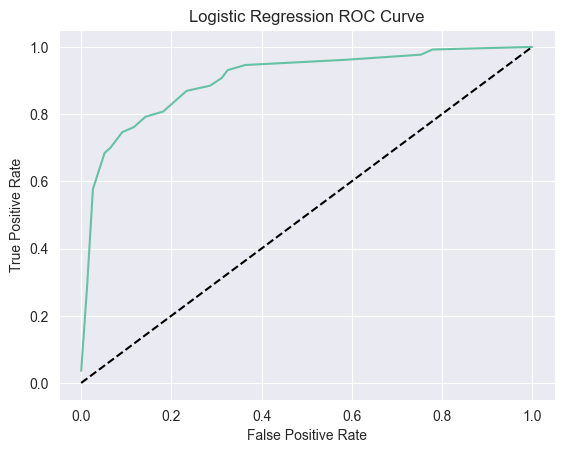

In [54]:
fpr,tpr,threshold=roc_curve(y_val,y_pred_props)
plt.plot([0, 1], [0, 1], 'k--')
sns.lineplot(x=fpr,y=tpr,errorbar=None)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [55]:
ROC_Score=roc_auc_score(y_val,y_pred_props)
ROC_Score

0.9050949050949052

### Applying Gridsearchcv with cross-validation

In [56]:
params={
    "C":[0.0001,0.001,0.1,0.3,0.5,1],
    "penalty":["l1","l2"]
}
kf=KFold(n_splits=5,shuffle=True,random_state=42)
logreg=LogisticRegression()

logreg_cv=GridSearchCV(logreg,params,cv=kf)
logreg_cv.fit(X_train_scaled,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.0001, 0.001, 0.1, 0.3, 0.5, 1],
                         'penalty': ['l1', 'l2']})

In [57]:
logreg_cv.best_params_,logreg_cv.best_score_

({'C': 0.1, 'penalty': 'l2'}, 0.8209386852085968)

In [58]:
y_pred_cv=logreg_cv.predict(X_val_scaled)

In [59]:
print(classification_report(y_val,y_pred_cv))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84        77
           1       0.80      0.82      0.81        65

    accuracy                           0.82       142
   macro avg       0.82      0.82      0.82       142
weighted avg       0.82      0.82      0.82       142



In [60]:
logreg_newton=LogisticRegression(solver="newton-cg")
logreg_newton.fit(X_train_scaled,y_train)

LogisticRegression(solver='newton-cg')

In [61]:
logreg_newton.score(X_val_scaled,y_val)

0.8169014084507042

In [62]:
y_pred_newton=logreg_newton.predict(X_val_scaled)

In [63]:
print(classification_report(y_val,y_pred_newton))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82        77
           1       0.77      0.85      0.81        65

    accuracy                           0.82       142
   macro avg       0.82      0.82      0.82       142
weighted avg       0.82      0.82      0.82       142

